# ATL06-SR Demo with Visualization
David Shean  
December 8, 2020

Testing current SlideRule functionality for Everest and Grand Mesa sites

In [1]:
import sys
import os
import logging
import time
import json
import pandas as pd
import numpy as np
import cartopy
import matplotlib.pyplot as plt
from datetime import datetime
from sliderule import icesat2

In [2]:
def process_atl06_algorithm(parms, asset):

    # Latch Start Time
    perf_start = time.perf_counter()

    # Request ATL06 Data
    rsps = icesat2.atl06p(parms, asset)

    # Latch Stop Time
    perf_stop = time.perf_counter()

    # Build DataFrame of SlideRule Responses
    df = pd.DataFrame(rsps)

    # Display Statistics
    perf_duration = perf_stop - perf_start
    print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
    print("Reference Ground Tracks: {}".format(df["rgt"].unique()))
    print("Cycles: {}".format(df["cycle"].unique()))
    print("Received {} elevations".format(len(df)))

    # Return DataFrame
    return df

In [3]:
# Configure Logging #
logging.basicConfig(level=logging.INFO)

In [4]:
# Region of Interest #
region_filename = 'everest.json'
#region_filename = 'ngozumpa.json'
with open(region_filename) as regionfile:
   # region = json.load(regionfile)["region"]
    region = json.load(regionfile)["region"]

In [5]:
#Can specify region manually
#Grand Mesa
"""
region = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
               {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
               {"lon": -107.7818591266989, "lat": 39.26613714985466},
               {"lon": -108.3605610678553, "lat": 39.25086131372244},
               {"lon": -108.3435200747503, "lat": 38.89102961045247} ]
"""

'\nregion = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},\n               {"lon": -107.7677425431139, "lat": 38.90611184543033}, \n               {"lon": -107.7818591266989, "lat": 39.26613714985466},\n               {"lon": -108.3605610678553, "lat": 39.25086131372244},\n               {"lon": -108.3435200747503, "lat": 38.89102961045247} ]\n'

In [6]:
# Set URL #
url = "http://44.227.4.67:9081"

# Set Asset #
asset = "atl03-cloud"
#asset = "atl06-cloud"

In [7]:
# Configure SlideRule
icesat2.init(url, True)

In [8]:
# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

In [9]:
out_fn = 'everest.pkl'
if not os.path.exists(out_fn):
    # Get ATL06 Elevations
    atl06 = process_atl06_algorithm(parms, asset)
    atl06.to_pickle(out_fn)
else:
    atl06 = pd.read_pickle(out_fn)

In [10]:
atl06.shape

(365106, 11)

In [11]:
atl06

@rectype  segment_id       h_mean        lat  dh_fit_dy  \
0       atl06rec.elevation      153517  5191.318103  27.691493        0.0   
1       atl06rec.elevation      153518  5190.246526  27.691671        0.0   
2       atl06rec.elevation      153519  5189.115314  27.691849        0.0   
3       atl06rec.elevation      153519  5187.966257  27.691849        0.0   
4       atl06rec.elevation      153617  5986.519214  27.709494        0.0   
...                    ...         ...          ...        ...        ...   
365101  atl06rec.elevation      848703  3472.157605  27.612768        0.0   
365102  atl06rec.elevation      848770  3387.960068  27.600707        0.0   
365103  atl06rec.elevation      848771  3388.817890  27.600523        0.0   
365104  atl06rec.elevation      848772  3400.412134  27.600351        0.0   
365105  atl06rec.elevation      848773  3387.238547  27.600167        0.0   

        dh_fit_dx  spot  cycle  rgt        lon    delta_time  
0       -0.053718     5      1  363  86.884963  1.224235e+09  
1       -0.057371     5      1  363  86.884944  1.224235e+09  
2       -0.056281     5      1  363  86.884924  1.224235e+09  
3       -0.061722     5      1  363  86.884924  1.224235e+09  
4       -0.015866     5      1  363  86.882877  1.224235e+09  
...           ...   ...    ...  ...        ...           ...  
365101  -0.030219     3      0    0  86.799169  8.420038e+07  
365102   0.004277     3      0    0  86.797806  8.420038e+07  
365103   0.789239     3      0    0  86.797784  8.420038e+07  
365104  -0.779991     3      0    0  86.797764  8.420038e+07  
365105  -0.878399     3      0    0  86.797744  8.420038e+07  

[365106 rows x 11 columns]

In [12]:
#Currently using astropy for GPS time handling
from astropy.time import Time

def time_convert(df):
    print("Converting GPS time to Pandas DateTime")
    
    #Some early ATL03 delta_time values use different reference epoch, need to correct these 
    t_ref1 = Time('2018-01-06T00:00:00', format='isot')
    t_ref2 = Time('1980-01-06T00:00:00', format='isot')
    t_off = t_ref1.gps - t_ref2.gps
    
    df.loc[df['delta_time'] < t_ref1.gps, 'delta_time'] += t_off 
    
    temp = Time(t_ref2.gps + df['delta_time'], format='gps')
    
    df['utc'] = pd.to_datetime(temp.isot)
    
    print("Converting timestamp to decyear")
    df['decyear'] = temp.decimalyear
    
    print("Resetting index and sorting")
    df.set_index('utc', inplace=True)
    df.sort_index(inplace=True)

In [13]:
from pyproj import Transformer
def add_xy(df):
    #Add x and y coords in web mercator (for now)
    crs = "EPSG:3857" #Web mercator
    transformer = Transformer.from_crs("EPSG:4326", crs)
    print("Reprojecting to %s" % crs)
    df['x'], df['y'] = transformer.transform(df['lat'].values, df['lon'].values)

In [14]:
time_convert(atl06)

Converting GPS time to Pandas DateTime
Converting timestamp to decyear
Resetting index and sorting


In [15]:
add_xy(atl06)

Reprojecting to EPSG:3857


In [16]:
atl06.head()

@rectype  segment_id       h_mean  \
utc                                                                    
2018-10-22 09:20:42.755  atl06rec.elevation      153449  4725.324070   
2018-10-22 09:20:42.757  atl06rec.elevation      153450  4725.317447   
2018-10-22 09:20:42.760  atl06rec.elevation      153451  4725.333271   
2018-10-22 09:20:42.763  atl06rec.elevation      153452  4725.332625   
2018-10-22 09:20:42.766  atl06rec.elevation      153453  4725.327428   

                               lat  dh_fit_dy  dh_fit_dx  spot  cycle  rgt  \
utc                                                                          
2018-10-22 09:20:42.755  27.676419        0.0  -0.000441     4      1  363   
2018-10-22 09:20:42.757  27.676597        0.0   0.000520     4      1  363   
2018-10-22 09:20:42.760  27.676781        0.0  -0.000218     4      1  363   
2018-10-22 09:20:42.763  27.676960        0.0  -0.000646     4      1  363   
2018-10-22 09:20:42.766  27.677146        0.0   0.001240     4      1  363   

                               lon    delta_time      decyear             x  \
utc                                                                           
2018-10-22 09:20:42.755  86.853696  1.224235e+09  2018.806546  9.668509e+06   
2018-10-22 09:20:42.757  86.853683  1.224235e+09  2018.806546  9.668508e+06   
2018-10-22 09:20:42.760  86.853663  1.224235e+09  2018.806546  9.668506e+06   
2018-10-22 09:20:42.763  86.853644  1.224235e+09  2018.806546  9.668503e+06   
2018-10-22 09:20:42.766  86.853623  1.224235e+09  2018.806546  9.668501e+06   

                                    y  
utc                                    
2018-10-22 09:20:42.755  3.208239e+06  
2018-10-22 09:20:42.757  3.208261e+06  
2018-10-22 09:20:42.760  3.208284e+06  
2018-10-22 09:20:42.763  3.208306e+06  
2018-10-22 09:20:42.766  3.208330e+06

In [17]:
import geopandas as gpd
import contextily as cx

In [18]:
atl06_gdf = gpd.GeoDataFrame(atl06, geometry=gpd.points_from_xy(atl06['lon'], atl06['lat']), crs='EPSG:4326')

In [19]:
n = 100000
t = atl06_gdf.sample(n=n)

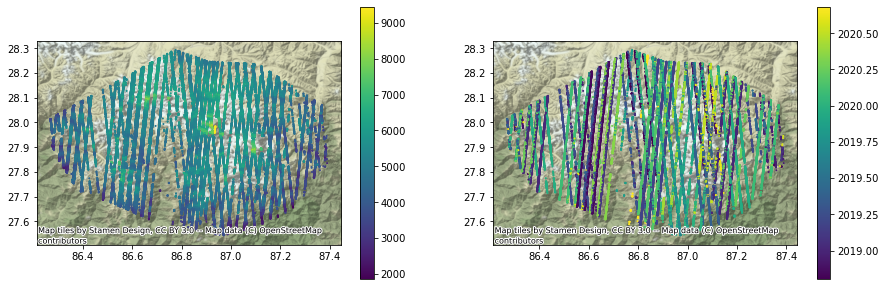

In [20]:
f, axa = plt.subplots(1,2, figsize=(15,5))
plot_kw = {'legend':True, 'markersize':1}
t.plot(ax=axa[0], column='h_mean', **plot_kw)
t.plot(ax=axa[1], column='decyear', **plot_kw)
cx.add_basemap(axa[0], crs=t.crs.to_string(), source=cx.providers.Stamen.Terrain)
cx.add_basemap(axa[1], crs=t.crs.to_string(), source=cx.providers.Stamen.Terrain)

In [21]:
import hvplot.pandas
from holoviews.element.tiles import EsriImagery, StamenTerrain

In [22]:
#map_tiles = EsriImagery()
map_tiles = StamenTerrain()

In [23]:
kw = {'cmap':'inferno', 'width':500, 'height':500, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade=True drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True

In [24]:
map_tiles * atl06.hvplot.scatter(x='x', y='y', c='h_mean', title='%s: %s' % ('ATL06-SR', 'h_mean'), **kw) + \
map_tiles * atl06.hvplot.scatter(x='x', y='y', c='dec_year', title='%s: %s' % ('ATL06-SR', 'dec_year'), **kw)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Overlay
         .Tiles.I :Tiles   [x,y]
         .RGB.I   :RGB   [x,y]   (R,G,B,A)
   .DynamicMap.II :DynamicMap   []
      :Overlay
         .Tiles.I :Tiles   [x,y]
         .RGB.I   :RGB   [x,y]   (R,G,B,A)

## Next Steps
* Retrieve and plot original ATL06 points
* Zoom for comparisons of ATL06-SR vs. ATL06